StudentID: 202314466

In [1]:
# import the libraries that we need
import os
import cv2
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from keras.models import Model
from keras.optimizers import Adam
from PIL import Image
import matplotlib.pyplot as plt

2023-08-03 14:38:23.972144: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We need to explore our dataset to read the contents of the data that we have in the unzipped directory. The directory name is "triple_mnist." The code below filters the contents to identify files with the extension ".png" and lists all the directories present in "triple_mnist" directory.

In [2]:
def is_image_file(filename):
    return filename.lower().endswith(('.png'))

# path to the dataset
directory = os.path.join('triple_mnist')

print('Root dir:', directory)

# list all files and directories in the specified directory
contents = os.listdir(directory)

# separate files and directories
files = []
directories = []

for item in contents:
    item_path = os.path.join(directory, item)
    if os.path.isfile(item_path) and is_image_file(item):
        files.append(item)
    elif os.path.isdir(item_path):
        directories.append(item)

print("The triple_mnist directory contains the following directories:", directories)

Root dir: triple_mnist
The triple_mnist directory contains the following directories: ['test', 'train', 'val']


The dataset contains 3 directories of test, train and validation directories. The files have images in subdirectories in ".png" format. We will then create variables train_dir, val_dir, and test_dir to store the paths to the training, validation, and test dataset directories, respectively.

In [3]:
# assign paths to the respective dataset directories
train_dir = os.path.join(directory, 'train')  # path to the train dataset directory

val_dir = os.path.join(directory, 'val')  # path to the validation dataset directory

test_dir = os.path.join(directory, 'test') # path to the test dataset directory

print("Train directory: ", train_dir)
print("Validation directory: ", val_dir)
print("Test directory: ", test_dir)

Train directory:  triple_mnist/train
Validation directory:  triple_mnist/val
Test directory:  triple_mnist/test


We need to check the dimension size of all the images to resize later so that we can improve the training model perfomance, by reducing training time and resource usage. Also as resizing is being done, will have to be keen to maintain the image quality. We also know the count of images we have in the train, test and validation data. Because the count of the images is big for the different directories, will print dimension size of a sample 5 images instead.

In [4]:
def count_images_and_dimensions(directory, sample_size): 
    total_images = 0
    image_dimensions = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if is_image_file(file):  # skip non-image files if there are any
                total_images += 1
                img = Image.open(file_path)
                height, width = img.size
                image_dimensions.append((height, width))
                img.close()
            if total_images >= sample_size:
                break
        if total_images >= sample_size:
            break
    return total_images, image_dimensions

sample_size = 5
train_images, train_dimensions = count_images_and_dimensions(train_dir, sample_size)
test_images, test_dimensions = count_images_and_dimensions(test_dir, sample_size)
val_images, val_dimensions = count_images_and_dimensions(val_dir, sample_size)

print("Train count: {} images".format(train_images))
print("Train image dimensions (height, width):", train_dimensions)
print("Test count: {} images".format(test_images))
print("Test image dimensions (height, width):", test_dimensions)
print("Validation count: {} images".format(val_images))
print("Validation image dimensions (height, width):", val_dimensions)

Train count: 5 images
Train image dimensions (height, width): [(84, 84), (84, 84), (84, 84), (84, 84), (84, 84)]
Test count: 5 images
Test image dimensions (height, width): [(84, 84), (84, 84), (84, 84), (84, 84), (84, 84)]
Validation count: 5 images
Validation image dimensions (height, width): [(84, 84), (84, 84), (84, 84), (84, 84), (84, 84)]


The images in the dataset are made up of 3 digit numbers. For ease of training, we decided to split the images into 3 parts. So, for each image part, it will contain a single digit. This will makes us have only 10 classes per image as part during training. That is 0-9. We shall first load the images from the 3 directories so that we can resize them to a 63 by 63 from a 84 by 84. This way we shall not lose clarity of the images and also improve the image processing performance. Thereafter, we shall split the image horizontally to 3 parts of size 21 pixels each and show the split images.

In [5]:
# create load_data function from the 3 directories
def load_data(directory):
    data = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for filename in files:
            filepath = os.path.join(root, filename)
            if is_image_file(filename) and os.path.isfile(filepath):
                image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)  # read the image in grayscale
                image = cv2.resize(image, (63, 63))  # resize the image to the target size for our sequential model
                data.append(image[:, :21])
                data.append(image[:, 21:42])
                data.append(image[:, 42:])
                label_triple = filename.split('.')[0].split('_')[1]
                labels.append(int(label_triple[0]))
                labels.append(int(label_triple[1]))
                labels.append(int(label_triple[2]))  # filenames are integers with labels
    return np.array(data), np.array(labels)

In [6]:
# load the train, test, and val data
X_train, y_train = load_data(train_dir)
X_test, y_test = load_data(test_dir)
X_val, y_val = load_data(val_dir)
# confirm the loaded data count and new size
print("Train dataset shape:",X_train.shape)
print("Test dataset shape:",X_test.shape)
print("Validation dataset shape:",X_val.shape)
print("y_train label:",y_train.shape)
print("y_test label:",y_test.shape)
print("y_val label",y_val.shape)

Train dataset shape: (49800, 63, 21)
Test dataset shape: (60000, 63, 21)
Validation dataset shape: (190200, 63, 21)
y_train label: (49800,)
y_test label: (60000,)
y_val label (190200,)


In [7]:
# visualize Preprocessed Images
def showImages(images):
    n_samples_to_visualize = len(images)
    fig, axes = plt.subplots(1, n_samples_to_visualize, figsize=(15, 3))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap="gray")  # Plot the ith image
    ax.axis('off')
    plt.show()

Image Shapes: {(63, 21)}
Pixel Value Range: 0 255


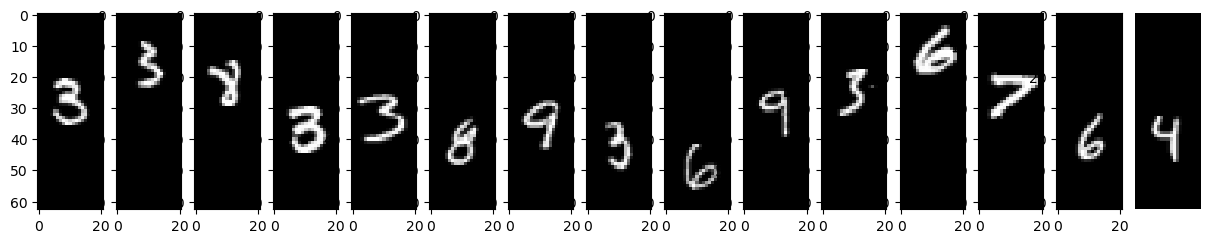

In [8]:
# verify Image Shape
print("Image Shapes:", set(img.shape for img in X_train))

# check Image Range
print("Pixel Value Range:", np.min(X_train), np.max(X_train))

# visualize Preprocessed Images
n_samples_to_visualize = 5
images = []
for i in range(n_samples_to_visualize):
    images.append(X_train[i*153])
    images.append(X_train[i*153+1])
    images.append(X_train[i*153+2])
showImages(images)    

For CNN model input data, we shall reshape the images into a 4D tensor format. 

In [9]:
# reshape the input data to a 4D tensor (batch_size, height, width, channels)
X_train = X_train.reshape(X_train.shape[0], 63, 21, 1)
X_val = X_val.reshape(X_val.shape[0], 63, 21, 1)
X_test = X_test.reshape(X_test.shape[0], 63, 21, 1)

After reshaping, we shall attempt to represent the labels, in a suitable format for our neural network. This process involves converting the class labels into binary vectors where each class is uniquely represented. In our case, we have a classification task with 10 different classes. To convert our target labels (y_train, y_val, and y_test) into one-hot encoded format, we use the tf.keras.utils.to_categorical() function provided by TensorFlow/Keras. This function takes the class labels and the number of classes as input and returns the one-hot encoded representation.

In [10]:
# convert the target labels to one-hot encoding
y_train_one_hot = tf.keras.utils.to_categorical(y_train, num_classes=10)
y_val_one_hot = tf.keras.utils.to_categorical(y_val, num_classes=10)
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes=10)

In [11]:
# print the shapes of the input and target data
print('Training data shape:', X_train.shape, y_train_one_hot.shape)
print('Test data shape:', X_test.shape, y_test.shape)
print('Validation data shape:', X_val.shape, y_val.shape)

Training data shape: (49800, 63, 21, 1) (49800, 10)
Test data shape: (60000, 63, 21, 1) (60000,)
Validation data shape: (190200, 63, 21, 1) (190200,)


Before building and training our CNN, it is important to define the input shape of the data and the total number of classes in the classification task. 

In [12]:
# define input shape and total number of classes
input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]) # determine the input shape of the data

num_classes = len(y_train_one_hot[0]) # determine the total number of classes (target labels)

# print out the results
print('Input shape: ', input_shape)
print('Number of target labels: ', num_classes)

Input shape:  (63, 21, 1)
Number of target labels:  10


After defeining our input shape and number of classes, we shall then create our Convolutional Neural Network (CNN) model for image classification using TensorFlow and Keras. The model architecture consists of convolutional layers, max pooling layers, a dropout layer for regularization, and a final dense layer for multi-class classification.

In [13]:
# function to create the CNN model
def create_model(shape, num_classes):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    return model

# instanciate the function
model = create_model(input_shape, num_classes)

After creating the CNN model, the next step is to compile it. Compiling the model involves configuring its learning process, an optimizer - optimizer determines how the model's parameters (weights and biases) are updated during training to minimize the loss function.
The loss function, and the evaluation metrics.

In [14]:
# compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 19, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 9, 32)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 7, 64)         18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 3, 64)        0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2688)              0         
                                                                 
 dropout (Dropout)           (None, 2688)              0

After compiling the CNN model, we need to train the model on the training data. Training the model involves inputing the training data to the network, adjusting its parameters based on the defined loss function and optimizer, and iteratively updating the weights to minimize the loss. For our case, we shall have 3 models that have been tuned differently. This is for comparison purposes on which model is the best for our dataset.

In [15]:
# train the model
epochs = 10
batch_size = 32

history = model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val_one_hot))

Epoch 1/10
1557/1557 [==============================] - 113s 72ms/step - loss: 1.1831 - accuracy: 0.6550 - val_loss: 0.2813 - val_accuracy: 0.9191
Epoch 2/10
1557/1557 [==============================] - 84s 54ms/step - loss: 0.4219 - accuracy: 0.8646 - val_loss: 0.2023 - val_accuracy: 0.9404
Epoch 3/10
1557/1557 [==============================] - 80s 51ms/step - loss: 0.3342 - accuracy: 0.8947 - val_loss: 0.1628 - val_accuracy: 0.9520
Epoch 4/10
1557/1557 [==============================] - 80s 52ms/step - loss: 0.2823 - accuracy: 0.9116 - val_loss: 0.1579 - val_accuracy: 0.9530
Epoch 5/10
1557/1557 [==============================] - 81s 52ms/step - loss: 0.2519 - accuracy: 0.9229 - val_loss: 0.1203 - val_accuracy: 0.9646
Epoch 6/10
1557/1557 [==============================] - 131s 84ms/step - loss: 0.2278 - accuracy: 0.9296 - val_loss: 0.1193 - val_accuracy: 0.9639
Epoch 7/10
1557/1557 [==============================] - 112s 72ms/step - loss: 0.2141 - accuracy: 0.9334 - val_loss: 0.109

Now that we have trained our model on the training and validation dataset, it is important to assess its performance on unseen data to gauge its ability to generalize to new examples. The loss value represents the difference between the predicted class probabilities and the actual one-hot encoded target labels. The accuracy value, indicates the fraction of correctly classified samples in the test set.

In [16]:
# evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_accuracy * 100:.2f}%")
print(f"Test loss: {test_loss:.4f}")

1875/1875 [==============================] - 20s 11ms/step - loss: 0.0963 - accuracy: 0.9710
Test accuracy: 97.10%
Test loss: 0.0963


From the model we have just trained we can see the evaluation results indicate that the CNN model has performed well on the unseen test data, achieving a high accuracy of 97.10% and a low test loss of 0.0963. These results suggest that the model is capable of generalizing to new and unseen examples and making accurate predictions on the test data. 

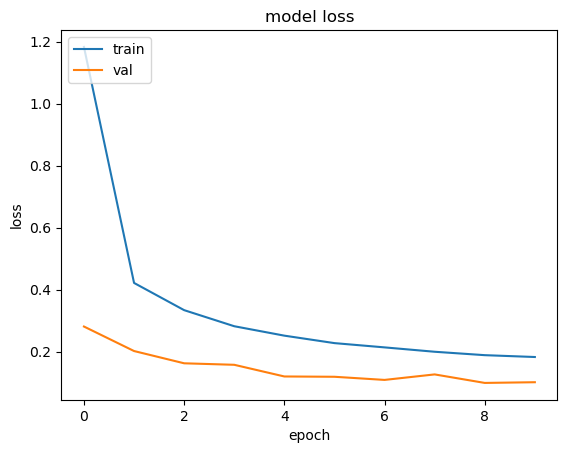

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Performance Analysis:
From the model loss graph above, we can observe a clear trend: as we train the data for more epochs, the test loss decreases gradually. This trend indicates that our CNN model is learning effectively and making progress in minimizing the discrepancies between the predictions and the actual target labels on the unseen test data. The decreasing test loss is a positive indicator of the model's performance. It suggests that the model is generalizing well to previously unseen data and improving its ability to make accurate predictions over time. 

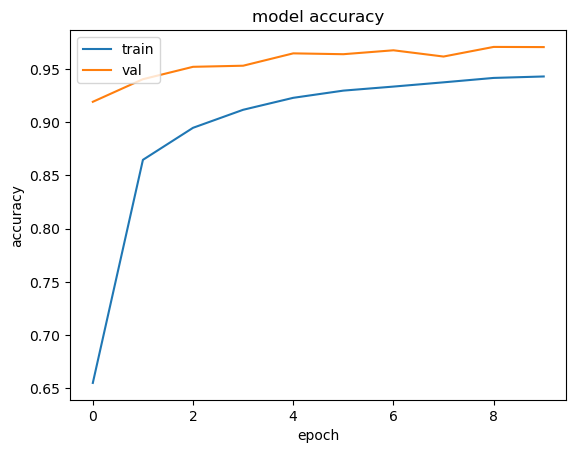

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Model Accuracy Analysis:
The model accuracy graph above shows the performance of our CNN model as it undergoes training epochs. From the graph, we can observe a trend where the accuracy of the model on both the training and validation datasets improves over time. As the number of training epochs increases, the accuracy on the training data increases. This behavior indicates that the model is learning well from the training data, capturing meaningful patterns, and becoming better at classifying data it has already seen.

We shall try fine tune our model to try achieve better accuracy results.

In [19]:
# function to create the CNN model
def create_model2(shape, num_classes):
    model2 = tf.keras.Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=shape),
        MaxPooling2D((2, 2)),
        Conv2D(25, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(40, (3, 3), activation='relu'),
        #MaxPooling2D((2, 2)),
        Flatten(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    return model2

In [20]:
# instanciate the model
model2 = create_model2(input_shape, num_classes)
# compile the model
optimizer = Adam(learning_rate=0.001)
model2.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 61, 19, 16)        160       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 9, 16)        0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 7, 25)         3625      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 3, 25)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 12, 1, 40)         9040      
                                                                 
 flatten_1 (Flatten)         (None, 480)              

In [21]:
# train the model
epochs = 10
batch_size = 32

history2 = model2.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val_one_hot))

Epoch 1/10
1557/1557 [==============================] - 93s 59ms/step - loss: 1.0042 - accuracy: 0.6621 - val_loss: 0.2292 - val_accuracy: 0.9321
Epoch 2/10
1557/1557 [==============================] - 77s 49ms/step - loss: 0.3111 - accuracy: 0.9013 - val_loss: 0.1292 - val_accuracy: 0.9611
Epoch 3/10
1557/1557 [==============================] - 73s 47ms/step - loss: 0.2202 - accuracy: 0.9310 - val_loss: 0.1241 - val_accuracy: 0.9646
Epoch 4/10
1557/1557 [==============================] - 69s 44ms/step - loss: 0.1725 - accuracy: 0.9463 - val_loss: 0.1113 - val_accuracy: 0.9680
Epoch 5/10
1557/1557 [==============================] - 75s 48ms/step - loss: 0.1467 - accuracy: 0.9554 - val_loss: 0.1027 - val_accuracy: 0.9702
Epoch 6/10
1557/1557 [==============================] - 59s 38ms/step - loss: 0.1354 - accuracy: 0.9578 - val_loss: 0.0794 - val_accuracy: 0.9772
Epoch 7/10
1557/1557 [==============================] - 57s 37ms/step - loss: 0.1214 - accuracy: 0.9632 - val_loss: 0.0772 -

In [22]:
# evaluate the model on test data
test_loss2, test_accuracy2 = model2.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_accuracy2 * 100:.2f}%")
print(f"Test loss: {test_loss2:.4f}")

1875/1875 [==============================] - 10s 5ms/step - loss: 0.0701 - accuracy: 0.9798
Test accuracy: 97.98%
Test loss: 0.0701


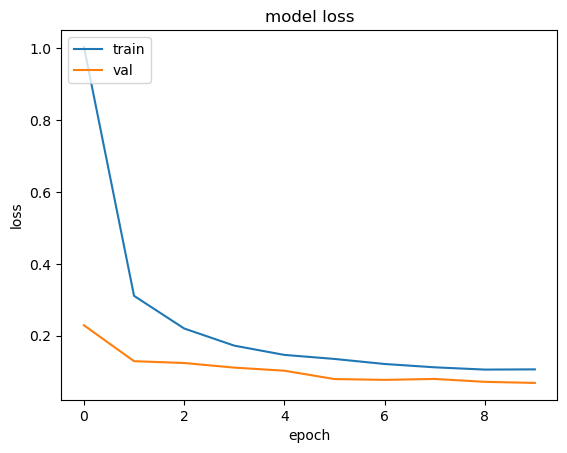

In [23]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

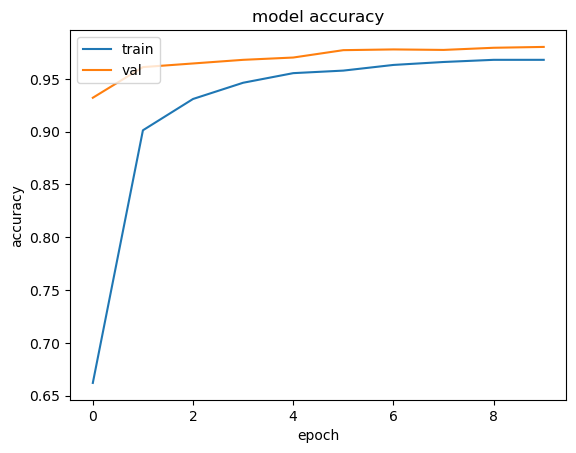

In [24]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
# Function to create the CNN model
def create_model3(shape, num_classes):
    model3 = tf.keras.Sequential([
        Conv2D(16, (3, 3), activation='relu', input_shape=shape),
        MaxPooling2D((2, 2)),
        Conv2D(25, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(40, (3, 3), activation='relu'),
        #MaxPooling2D((2, 2)),
        Flatten(),
        #Dropout(0.5),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    return model3

In [26]:
# Create the model
model3 = create_model3(input_shape, num_classes)
# Compile the model
optimizer = Adam(learning_rate=0.001)
model3.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 61, 19, 16)        160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 9, 16)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 28, 7, 25)         3625      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 3, 25)        0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 12, 1, 40)         9040      
                                                                 
 flatten_2 (Flatten)         (None, 480)              

In [27]:
# Train the model
epochs = 10
batch_size = 32

history3 = model3.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_val, y_val_one_hot))

Epoch 1/10
1557/1557 [==============================] - 65s 42ms/step - loss: 0.4901 - accuracy: 0.8491 - val_loss: 0.1848 - val_accuracy: 0.9439
Epoch 2/10
1557/1557 [==============================] - 61s 39ms/step - loss: 0.1421 - accuracy: 0.9555 - val_loss: 0.1235 - val_accuracy: 0.9632
Epoch 3/10
1557/1557 [==============================] - 69s 44ms/step - loss: 0.1028 - accuracy: 0.9673 - val_loss: 0.1229 - val_accuracy: 0.9637
Epoch 4/10
1557/1557 [==============================] - 68s 44ms/step - loss: 0.0802 - accuracy: 0.9747 - val_loss: 0.1326 - val_accuracy: 0.9621
Epoch 5/10
1557/1557 [==============================] - 54s 35ms/step - loss: 0.0684 - accuracy: 0.9777 - val_loss: 0.1101 - val_accuracy: 0.9700
Epoch 6/10
1557/1557 [==============================] - 66s 43ms/step - loss: 0.0563 - accuracy: 0.9816 - val_loss: 0.1072 - val_accuracy: 0.9715
Epoch 7/10
1557/1557 [==============================] - 61s 39ms/step - loss: 0.0522 - accuracy: 0.9834 - val_loss: 0.1787 -

In [28]:
# Evaluate the model on test data
test_loss3, test_accuracy3 = model3.evaluate(X_test, y_test_one_hot)
print(f"Test accuracy: {test_accuracy3 * 100:.2f}%")
print(f"Test loss: {test_loss3:.4f}")

1875/1875 [==============================] - 13s 7ms/step - loss: 0.1199 - accuracy: 0.9714
Test accuracy: 97.14%
Test loss: 0.1199


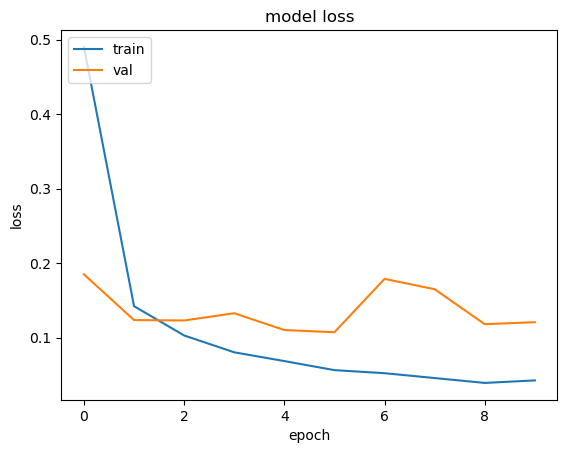

In [29]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

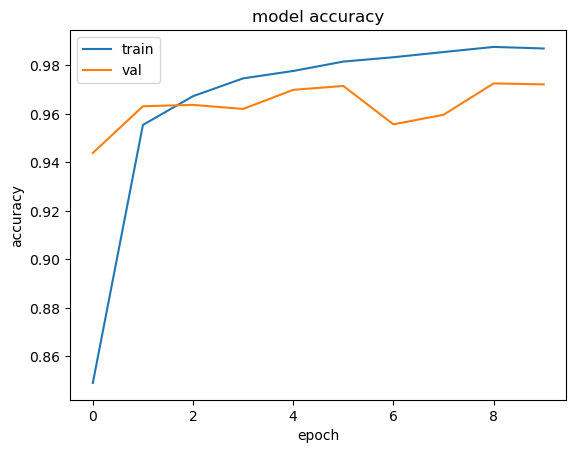

In [30]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Summary
In the provided code, we evaluated three different models, named model, model2, and model3, on the test dataset to assess their performance. Each model was trained on the training dataset and evaluated on unseen data to determine how well it can generalize to new examples.

The evaluation results for each model are as follows:

model:-
Test accuracy: 97.10%
Test loss: 0.0963

model2:- 
Test accuracy: 97.98%
Test loss: 0.0701

model3:-
Test accuracy: 97.14%
Test loss: 0.1199

The test accuracy represents the percentage of correctly classified samples in the test dataset. As we can observe, model2 achieved the highest test accuracy at 97.98%, indicating that it correctly classified nearly 98 out of every 100 test examples. This suggests that model has learned meaningful patterns from the training data and can effectively generalize to unseen data.

On the other hand, model achieved a test accuracy of 97.10%, and model3 achieved a test accuracy of 97.14%. While these accuracies are reasonable, they are lower compared to model2. It is possible that model and model3 may require further optimization or adjustments to achieve better performance.

The test loss measures the alignment between the model's predicted probabilities and the actual one-hot encoded target labels on the test data. Lower test loss values indicate better model performance. Here, we can observe that model2 has the lowest test loss at 0.0701, while model and model3 have higher test losses of 0.0963 and 0.1199, respectively.

In conclusion, the evaluation results indicate that model2 performed the best among the three models, achieving high accuracy and low test loss on the test dataset. This suggests that model2 is the best model for our application, as it has demonstrated superior generalization capabilities and effective classification performance on previously unseen data.